# Nonparametric quantification of uncertainty of text classification models using conformal prediction

## Dataset

### Loading

In [ ]:
from datasets import load_dataset
import numpy as np
dataset = load_dataset('amazon_polarity')

smaller_dataset = dataset
smaller_dataset["train"] = smaller_dataset["train"].filter(lambda e, i: i<18000, with_indices=True)
smaller_dataset["test"] = smaller_dataset["test"].filter(lambda e, i: i<2000, with_indices=True)

### BERT Tokenizer

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
smaller_tokenized_dataset = smaller_dataset.map(preprocess_function, batched=True)

### Word embeddings

In [4]:
from gensim.models import KeyedVectors

model_word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [5]:
import nltk
from nltk.corpus import stopwords

def preprocess(sentence):
    nltk.word_tokenize(sentence)
    sentence = [word for word in sentence if word not in stopwords.words('english')]
    sentence = [model_word_vectors.get_vector(w) for w in sentence if w in model_word_vectors.key_to_index]
    return np.stack(sentence, axis=0).mean(0).reshape(300,) if len(sentence) > 0 else np.zeros(300,)

In [ ]:
from tqdm import tqdm
import pandas as pd
from pandarallel import pandarallel
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

X_train_word_embeddings = np.stack(pd.Series(smaller_dataset["train"]["title"]).parallel_apply(lambda x: preprocess(x)).values, axis=0)
y_train_word_embeddings = np.array(smaller_dataset["train"]["label"])

X_test_word_embeddings = np.stack(pd.Series(smaller_dataset["test"]["title"]).parallel_apply(lambda x: preprocess(x)).values, axis=0)
y_test_word_embeddings = np.array(smaller_dataset["test"]["label"])

## Models

### BERT

In [ ]:
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=smaller_tokenized_dataset["train"],
    eval_dataset=smaller_tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

In [ ]:
import torch
predicted = trainer.predict(smaller_tokenized_dataset["test"])

predicted_proba = torch.nn.functional.softmax(torch.tensor(predicted.predictions), dim=1)
data_bert = predicted_proba[:,1].numpy(), np.array(smaller_tokenized_dataset["test"]["label"])

<AxesSubplot:ylabel='Count'>

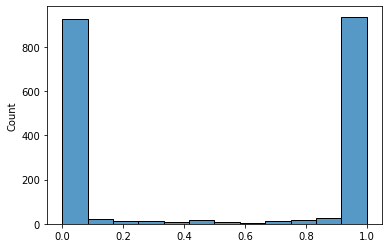

In [10]:
import seaborn as sns
sns.histplot(data_bert[0])

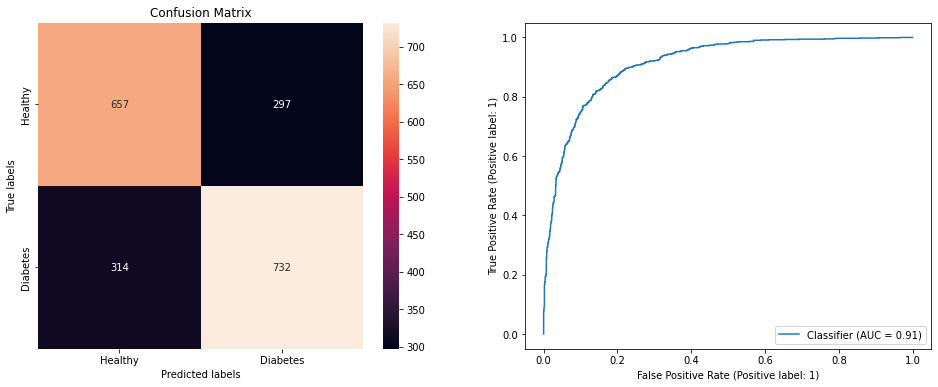

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat = (data_lgb[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_lgb[1], y_hat), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted labels');ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Healthy', 'Diabetes']); ax[0].yaxis.set_ticklabels(['Healthy', 'Diabetes'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_lgb[1], predicted_proba[:,1], ax=ax[1])

### SVM

In [ ]:
from sklearn import svm
from sklearn.ensemble import BaggingClassifier

n_estimators = 4
model_svm = BaggingClassifier(svm.SVC(probability=True), max_samples=1.0 / n_estimators, n_jobs=-1)
model_svm.fit(X_train_word_embeddings, y_train_word_embeddings)

In [12]:
data_svm = model_svm.predict_proba(X_test_word_embeddings)[:,1], np.array(y_test_word_embeddings)

<AxesSubplot:ylabel='Count'>

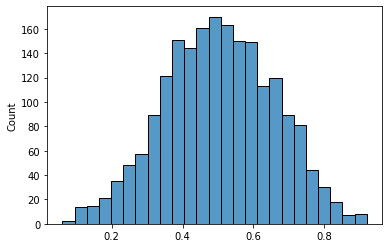

In [13]:
import seaborn as sns
sns.histplot(data_svm[0])

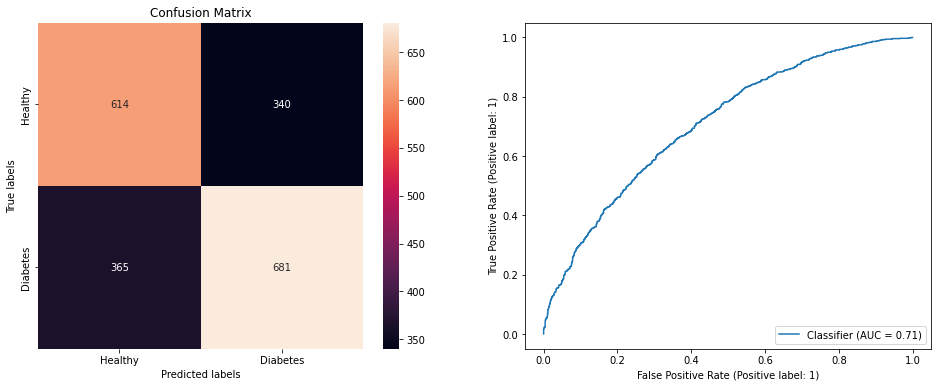

In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat = (data_svm[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_svm[1], y_hat), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted labels');ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Healthy', 'Diabetes']); ax[0].yaxis.set_ticklabels(['Healthy', 'Diabetes'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_svm[1], data_svm[0], ax=ax[1])

### LightGBM

In [16]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier()
model_lgb.fit(X_train_word_embeddings, y_train_word_embeddings)

LGBMClassifier()

In [17]:
data_lgb = model_lgb.predict_proba(X_test_word_embeddings)[:,1], np.array(y_test_word_embeddings)

<AxesSubplot:ylabel='Count'>

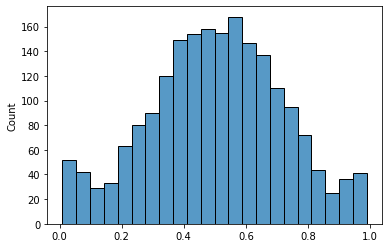

In [18]:
import seaborn as sns
sns.histplot(data_lgb[0])

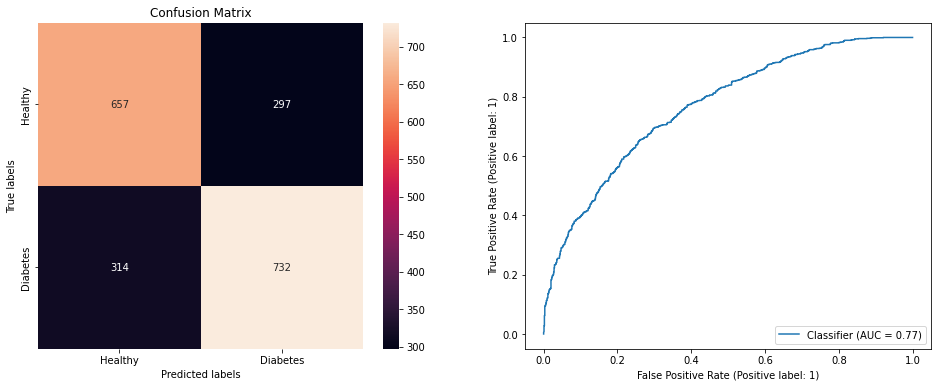

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     

threshold = 0.5
y_hat = (data_lgb[0] > threshold).astype('float')

fig, ax = plt.subplots(1, 2, figsize=(16,6))
sns.heatmap(confusion_matrix(data_lgb[1], y_hat), annot=True, fmt='g', ax=ax[0])
ax[0].set_xlabel('Predicted labels');ax[0].set_ylabel('True labels'); 
ax[0].set_title('Confusion Matrix')
ax[0].xaxis.set_ticklabels(['Healthy', 'Diabetes']); ax[0].yaxis.set_ticklabels(['Healthy', 'Diabetes'])

from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(data_lgb[1], data_lgb[0], ax=ax[1])

## Evaluation

**Supporting code**

In [32]:
import VennAbers
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
import matplotlib.pyplot as plt

def plot_venn_abers(data):
    venn_abers = VennAbers.venn_abers_fast(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.3)
    plt.axis((0, 1, 0, 1))

def plot_isotonic_regression(data):
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(18,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba)
    plt.axis((0, 1, 0, 1))
    
def plot_all(data):
    venn_abers = VennAbers.venn_abers_fast(list(zip(data[0], data[1])), np.array(list(range(0, 101, 1))) / 100)
    ir = IsotonicRegression()
    ir.fit(data[0], data[1])
    predicted_proba = ir.predict(np.array(list(range(0, 101, 1))) / 100)
    plt.figure(figsize=(10,10))
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=(venn_abers[0] + venn_abers[1]) / 2)
    plt.fill_between(np.array(list(range(0, 101, 1))) / 100, venn_abers[0], venn_abers[1], alpha=.15)
    sns.lineplot(x=np.array(list(range(0, 101, 1))) / 100, y=predicted_proba, linestyle='dotted')
    plt.axis((0, 1, 0, 1))
    
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, linestyle='--', color='grey', lw=1, scalex=False, scaley=False)
    
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.legend(["Venn-Abers", "Venn-Abers Interval", "Isotonic Regression"])
    plt.xlabel('Model probability'); plt.ylabel('Calibrated probability')

### BERT

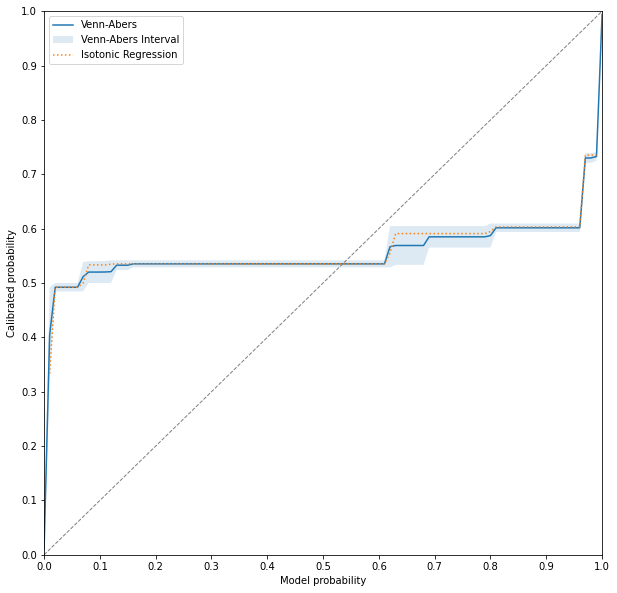

In [33]:
plot_all(data_bert)

### SVM

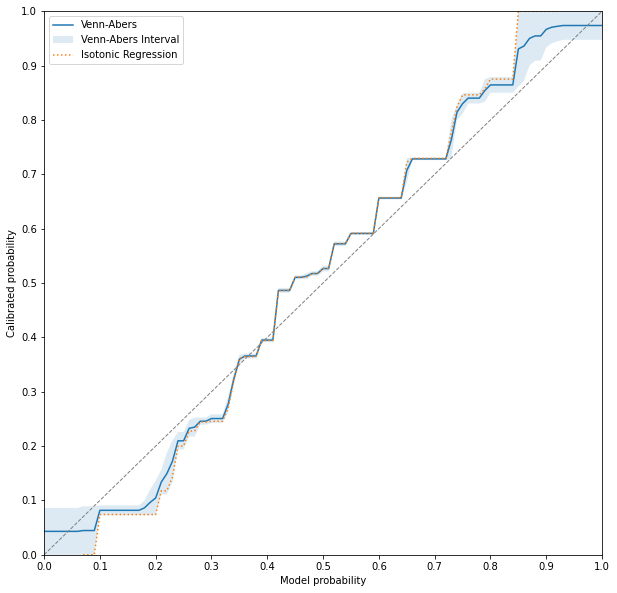

In [34]:
plot_all(data_svm)

### LightGBM

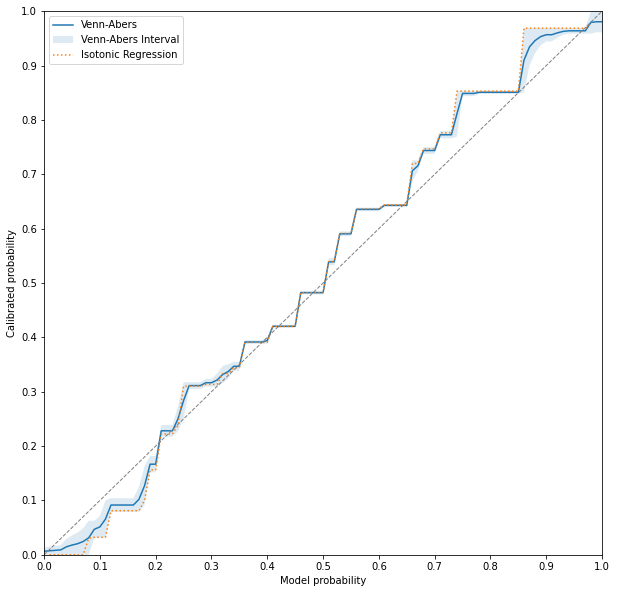

In [35]:
plot_all(data_lgb)

## Time evaluation

In [24]:
import time
import VennAbers
from tqdm import tqdm
data_time_eval = data_lgb

In [25]:
def time_eval_slow(rounds=100):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        for s_x_test in (np.array(list(range(0, 101, 1))) / 100):
            venn_abers = VennAbers.venn_abers(list(zip(data_time_eval[0], data_time_eval[1])), s_x_test)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [26]:
def time_eval_fast(rounds=100):
    total_time = 0
    for i in range(rounds):
        start = time.time()
        venn_abers = VennAbers.venn_abers_fast(list(zip(data_time_eval[0], data_time_eval[1])), np.array(list(range(0, 101, 1))) / 100)
        end = time.time()
        total_time += end - start
    return total_time / rounds * 1000

In [27]:
time_slow, time_fast = time_eval_slow(), time_eval_fast()
print(f"Slow Venn-Abers (avg. - 100 runs): {round(time_slow)} ms")
print(f"Fast Venn-Abers (avg. - 100 runs): {round(time_fast)} ms")
print(f"Average speed-up of {round((1/time_fast) / (1/time_slow), 1)}x (100 runs)")

Slow Venn-Abers (avg. - 100 runs): 155 ms
Fast Venn-Abers (avg. - 100 runs): 84 ms
Average speed-up of 1.8x (100 runs)
